In [3]:
### UCSD ECE269 Winter 2018
### Homework Set #7, Programming Assignment
### By Shouvik Ganguly
### Loading data from images

using Images

s1 = "Images/";
s2 = "b.jpg";
s3 = "a.jpg";

X = reshape(Float64[], 31266, 0);
Y = X;

for ii = 1:200
    
    if(ii < 10)
        sname = Char(48 + ii);
    elseif((ii >= 10) && (ii < 100))
        unitsplace = mod(ii, 10);
        tensplace = Int(floor(ii/10));
        sname = Char(48+tensplace)*Char(48+unitsplace);
    else
        hundredsplace = Int(floor(ii/100));
        tensplace = Int(floor((ii - (100*hundredsplace))/10));
        unitsplace = mod(ii, 10);
        sname = Char(48+hundredsplace)*Char(48+tensplace)*Char(48+unitsplace);
    end
    
    imgname = s1*sname*s2;
    img = load(imgname);
    X = [X vec(convert(Array{Float64},channelview(img)))];
    
    imgname = s1*sname*s3;
    img = load(imgname);
    Y = [Y vec(convert(Array{Float64},channelview(img)))];
    
end
    


INFO: Precompiling module QuartzImageIO.


In [41]:
Xmean=[mean(X[:,1])]
for i=2:200
    Xmean=[Xmean mean(X[:,i])]
end
Xtmp=zeros(31266,200)
for i=1:31266
    Xtmp[i,:]=X[i,:]-Xmean[:]
end
X=Xtmp;

In [42]:
Ymean=[mean(Y[:,1])]
for i=2:200
    Ymean=[Ymean mean(Y[:,i])]
end
Ytmp=zeros(31266,200)
for i=1:31266
    Ytmp[i,:]=Y[i,:]-Ymean[:]
end
Y=Ytmp;

In [43]:
Xtrain = X[:, 1:180];
Ytrain = Y[:, 1:180];

Xtest = X[:, 181:200];
Ytest = Y[:, 181:200];

In [71]:
### Part 1(a): Function definition

function pcaimg(data, numcomp)
    
    m=length(data[:,1])
    n=length(data[1,:])
    U, S, V = svd(data);
    U=U[:,1:numcomp]
    return U;
    
end    

pcaimg (generic function with 1 method)

In [126]:
function dykstra_svm(A,s,iter) #from HW 6
    m = size(A)[1];
    n = size(A)[2];
    
    v0 = zeros(n, 1);
    Z = zeros(n, m);
    
    count = 0;
           
    while(count < iter) #stopping conditions here
        
        ii = mod(count, m) + 1
        
        # Projection of v on the halfspace {x: a'x >= b}
        affineprojection = (a, b, v)-> (dot(vec(a), v) < b) ? (v - ((dot(vec(a),v) - b)/(norm(a)^2))*a) : v; 
        
        v1 = affineprojection(s[ii]*vec(A[ii,:]), 1, v0 - Z[:, ii]);
        Z[:, ii] = v1 - (v0 - Z[:, ii]);
        count = count + 1;
        v0 = v1;
        
    end
    
    x = v0;

    return x;
end

dykstra_svm (generic function with 1 method)

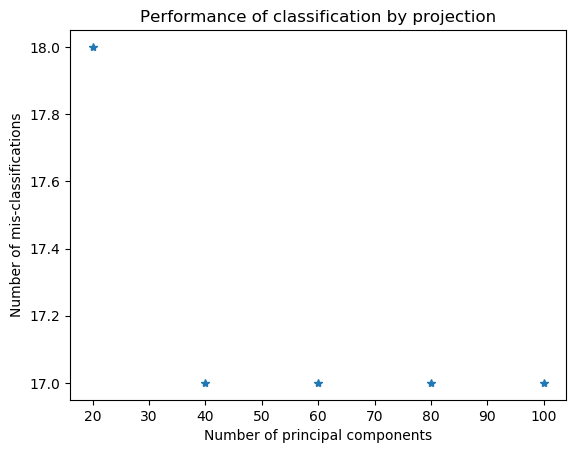

In [133]:
### Parts 1(b), 1(c), 1(d)

data = [Xtrain Ytrain];
data2= [Xtest Ytest];
numcomp = linspace(20, 100, 5);
nmis1 = zeros(1, length(numcomp)); # number of mis-classifications for each value of numcomp

s = [ones(1, 180) -ones(1, 180)];

for ii = 1:length(numcomp)
    
    U = pcaimg(data, Integer(numcomp[ii]));
    
    # Project data on the column space of U and come up with a separating hyperplane
    # Calculate nmis1[ii]
    Pdata=U'*data;
    Pdata2=U'*data2;
    predict=Pdata2'*dykstra_svm(Pdata',s,1000);
    #nmis1[ii]=0
    for i = 1:20
        if predict[i]<0
            nmis1[ii]+=1
        end
    end
    for i = 21:40
        if predict[i]>0
            nmis1[ii]+=1
        end
    end

end

# Plot the results

using PyPlot
plot(numcomp, vec(nmis1), linestyle=" ", marker="*");
title("Performance of classification by projection");
xlabel("Number of principal components");
ylabel("Number of mis-classifications");

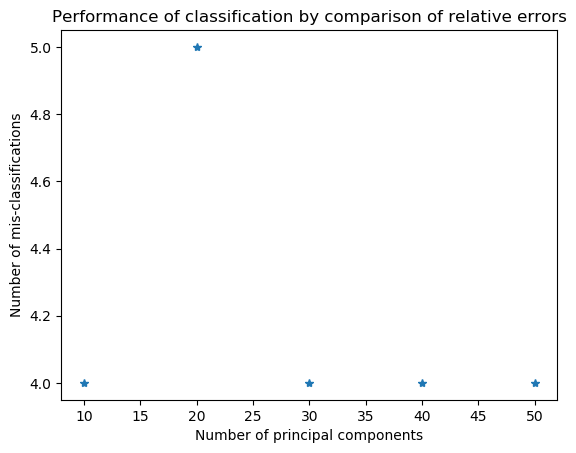

In [154]:
### Parts 1(e), 1(f)

numcomp = linspace(10, 50, 5);
nmis2 = zeros(1, length(numcomp)); # number of mis-classifications for each value of numcomp
data2= [Xtest Ytest];

for ii = 1:length(numcomp)
    
    U1 = pcaimg(Xtrain, Integer(numcomp[ii]));
    U2 = pcaimg(Ytrain, Integer(numcomp[ii]));
    # Project each face vector in [Xtest Ytest] on the column spaces of U1 and U2
    # Classify on the basis of relative errors and calculate nmis2[ii]
    P1=U1*U1'*data2;
    P2=U2*U2'*data2;
    e1=zeros(40)
    e2=zeros(40)
    for i=1:40
        e1[i]=norm(data2[:,i]-P1[:,i])*1./norm(data2[:,i]);
        e2[i]=norm(data2[:,i]-P2[:,i])*1./norm(data2[:,i]);
    end
    for i = 1:20
        if e1[i]>e2[i]
            nmis2[ii]+=1
        end
    end
    for i = 21:40
        if e1[i]<e2[i]
            nmis2[ii]+=1
        end
    end
    
end

# Plot the results

using PyPlot
plot(numcomp, vec(nmis2), linestyle=" ", marker="*");
title("Performance of classification by comparison of relative errors");
xlabel("Number of principal components");
ylabel("Number of mis-classifications");